# Parameter Optimisation SVM
## Ikjot Singh 
## 102116071   
## 3CS11

### Importing libraries

In [1]:
import random
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Fetching the dataset from UCI repository

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
chess_king_rook_vs_king = fetch_ucirepo(id=23) 
  
# data (as pandas dataframes) 
X = chess_king_rook_vs_king.data.features 
y = chess_king_rook_vs_king.data.targets 
  
# metadata 
print(chess_king_rook_vs_king.metadata) 
  
# variable information 
print(chess_king_rook_vs_king.variables) 


{'uci_id': 23, 'name': 'Chess (King-Rook vs. King)', 'repository_url': 'https://archive.ics.uci.edu/dataset/23/chess+king+rook+vs+king', 'data_url': 'https://archive.ics.uci.edu/static/public/23/data.csv', 'abstract': 'Chess Endgame Database for White King and Rook against Black King (KRK).', 'area': 'Games', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 28056, 'num_features': 6, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['white-depth-of-win'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C57W2S', 'creators': ['Michael Bain', 'Arthur Hoff'], 'intro_paper': None, 'additional_info': {'summary': "An Inductive Logic Programming (ILP) or relational learning framework is assumed (Muggleton, 1992). The learning system is provided with examples of chess positions described only by the coordinates

### Concatenating X and Y to make a dataframe

In [3]:
df=pd.concat([X,y],axis=1)

In [4]:
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28056 entries, 0 to 28055
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   white-king-file     28056 non-null  object
 1   white-king-rank     28056 non-null  int64 
 2   white-rook-file     28056 non-null  object
 3   white-rook-rank     28056 non-null  int64 
 4   black-king-file     28056 non-null  object
 5   black-king-rank     28056 non-null  int64 
 6   white-depth-of-win  28056 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.5+ MB


### Finding the number unique values in columns

In [6]:
# unique values in all columns
for col in df.columns:
    print(col, df[col].nunique())

white-king-file 4
white-king-rank 4
white-rook-file 8
white-rook-rank 8
black-king-file 8
black-king-rank 8
white-depth-of-win 18


### Converting all categorical columns to numerical

In [7]:
# convert all columns to numerical

label_encoder = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])

In [8]:
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,0,1,1,3,2,2,0
1,0,1,2,1,2,2,0
2,0,1,2,1,3,1,0
3,0,1,2,1,3,2,0
4,0,1,2,2,2,1,0


### Standard Scaling

In [9]:
# apply standard scaler

scaler = StandardScaler()

X = df.drop('white-depth-of-win', axis=1)
y = df['white-depth-of-win']

X = scaler.fit_transform(X)
df=pd.concat([pd.DataFrame(X),y],axis=1)

In [10]:
df

,0,1,2,3,4,5,white-depth-of-win
0,-2.251158,-0.921857,-1.107784,-0.662555,-0.877129,-1.090495,0
1,-2.251158,-0.921857,-0.672636,-1.538718,-0.877129,-1.090495,0
2,-2.251158,-0.921857,-0.672636,-1.538718,-0.444273,-1.535266,0
3,-2.251158,-0.921857,-0.672636,-1.538718,-0.444273,-1.090495,0
4,-2.251158,-0.921857,-0.672636,-1.100637,-0.877129,-1.535266,0
...,...,...,...,...,...,...,...
28051,-1.183859,-0.921857,1.067955,1.089769,-0.011417,0.243819,11
28052,-1.183859,-0.921857,1.067955,1.089769,-0.011417,0.688590,11
28053,-1.183859,-0.921857,1.067955,1.089769,-0.011417,1.133361,11
28054,-1.183859,-0.921857,1.067955,1.089769,0.421439,0.243819,11


### Generating 10 random samples

In [11]:
samples = []
for i in range(10):
    samples.append(df.sample(n=2000))

### SVM Trainer

In [14]:
def train_svm(X_train,y_train,X_test,y_test, kernel ,C, gamma):
    clf = svm.SVC(kernel=kernel, C=C, gamma=gamma,max_iter=2000)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

### Finding the Best Parameters

In [15]:
dataframes = []
result = pd.DataFrame(columns = ['Sample Number', 'Best Kernel', 'Best C', 'Best Gamma', 'Best Accuracy'])
for num,sample in enumerate(samples, start=1):
    df = pd.DataFrame(columns = ['iteration', 'kernel', 'C', 'gamma', 'accuracy'])
    X = sample.drop(['white-depth-of-win'], axis=1)
    y = sample['white-depth-of-win']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    kernelList = ['linear', 'poly', 'rbf', 'sigmoid']
    best_accuracy = 0
    for i in range(100):
        k = random.random()
        n = random.random()
        kernel = random.choice(kernelList)
        accuracy = train_svm(X_train,y_train,X_test,y_test, kernel, k, n)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_kernel = kernel
            best_C = k
            best_gamma = n
            df = df.append({'iteration': i, 'kernel': kernel, 'C': k, 'gamma': n, 'accuracy': accuracy}, ignore_index=True)
    dataframes.append(df)
    result = result.append({'Sample Number': "sample {}".format(num), 'Best Kernel': best_kernel, 'Best C': best_C, 'Best Gamma': best_gamma, 'Best Accuracy': best_accuracy}, ignore_index=True)

C:\Users\Ikjot singh\AppData\Local\Temp\ipykernel_13384\3622116431.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'iteration': i, 'kernel': kernel, 'C': k, 'gamma': n, 'accuracy': accuracy}, ignore_index=True)
c:\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Ikjot singh\AppData\Local\Temp\ipykernel_13384\3622116431.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'iteration': i, 'kernel': kernel, 'C': k, 'gamma': n, 'accuracy': accuracy}, ignore_index=True)
c:\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your dat

In [20]:
result

,Sample Number,Best Kernel,Best C,Best Gamma,Best Accuracy
0,sample 1,rbf,0.817659,0.810218,0.421667
1,sample 2,rbf,0.943595,0.494702,0.458333
2,sample 3,rbf,0.988984,0.651963,0.425000
3,sample 4,rbf,0.930630,0.928545,0.448333
4,sample 5,rbf,0.981339,0.639373,0.463333
5,sample 6,rbf,0.856669,0.314991,0.445000
6,sample 7,rbf,0.805679,0.377687,0.406667
7,sample 8,rbf,0.934875,0.538442,0.411667
8,sample 9,rbf,0.984008,0.886660,0.465000
9,sample 10,rbf,0.924611,0.453191,0.446667


In [18]:
result[result['Best Accuracy'] == result['Best Accuracy'].max()]

,Sample Number,Best Kernel,Best C,Best Gamma,Best Accuracy
8,sample 9,rbf,0.984008,0.88666,0.465


### Plotting the Accuracy v/s Iterations graph

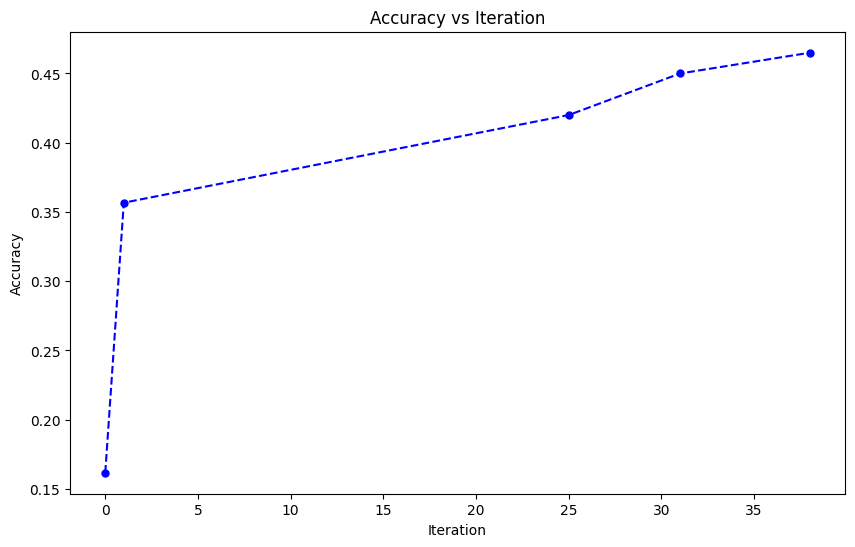

In [19]:
idx=result[result['Best Accuracy'] == result['Best Accuracy'].max()]['Sample Number'].index[0]

plt.figure(figsize=(10,6))
plt.plot(dataframes[idx]['iteration'],dataframes[idx]['accuracy'], color='blue', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=5)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iteration')
plt.show()